#Nächste Schritte:
- Andere Metriken als confusion matrix benutzen (Classification Metric mit TF,TN,FP,FN)
- Bilder zwischenspeichern nach der Bearbeitung -erledigt
- Model speichern nach dem Trainieren -erledigt aber vielleicht besser in einer anderen datei?
- testen, ob bestimmte hunderassen besser erkannt werden als andere
- evtl Code besser strukturieren/Aufteilen in verschiedene Dateien bzw Klassen

#Projekt: Hunderassenklassifizierung mit Deep Learning

**Workflow**
1. Daten laden und vorverarbeiten 
2. Daten und Klassenverteilung visualisieren
3. Modell (MobileNetV2) bauen und trainieren  
4. Modell evaluieren (Confusion Matrix, weitere Metriken)  
5. Modell und LabelEncoder speichern

## Bibliotheken importieren 

Importert alle benötigten Bibliotheken für Datenverarbeitung, Visualisierung und Modellierung

In [1]:
%pip install tensorflow

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

import warnings
warnings.filterwarnings('ignore')

Note: you may need to restart the kernel to use updated packages.


In [2]:
#...existing code...
#Konstanten setzen
BATCH_SIZE = 32
LEARNING_RATE = 0.001
DROPOUT_RATE = 0.7
#EPOCHS = 5
#...existing code...

In [3]:
#...existing code...
# Verzeichnisse für Trainings- und Testdaten füllen
train_dir ='input/train'
test_dir ='input/test'
#...existing code...

## Datensatzgröße anzeigen

Zeigt die Anzahl der Trainings- und Testbilder

In [4]:
# Anzahl der Bilder im Trainings- und Testset
train_size = len(os.listdir('input/train'))
test_size = len(os.listdir('input/test'))

train_size,test_size

(10222, 10357)

In [ ]:
# Lädt alle Bilder aus einem Ordner, skaliert sie auf 224x224 Pixel und gibt ein Dictionary zurück
# Braucht man nur beim ersten Durchlauf, um die Bilder zu laden und zu skalieren

#Füllen der Variablen train_images und test_images mit den Bilddaten
def load_images_from_folder(folder): # folder ist der Pfad zum Ordner mit den Bildern
    images = {}
    for filename in os.listdir(folder):
        path = os.path.join(folder, filename)
        with Image.open(path) as img:
            img = img.resize((224, 224))  # Einheitliche Größe
            images[filename] = np.array(img)
    return images

# Bilder laden
train_images = load_images_from_folder(train_dir)
test_images = load_images_from_folder(test_dir)

In [ ]:
# Hilfsklasse zum Speichern der verarbeiteten Bilder
class ImageSave:
    def __init__(self, test_images, train_images, processed_test_dir="processed/test", processed_train_dir="processed/train"):
        self.test_images = test_images
        self.train_images = train_images
        self.processed_test_dir = processed_test_dir
        self.processed_train_dir = processed_train_dir

    def save_images(self):
        # Speichern der Testbilder
        for filename, image_array in self.test_images.items():
            img = Image.fromarray(image_array.astype('uint8'))
            save_path = os.path.join(self.processed_test_dir, filename)
            img.save(save_path)
        print(f"{len(self.test_images)} verarbeitete Bilder in '{self.processed_test_dir}' gespeichert.")

        # Speichern der Trainingsbilder
        for filename, image_array in self.train_images.items():
            img = Image.fromarray(image_array.astype('uint8'))
            save_path = os.path.join(self.processed_train_dir, filename)
            img.save(save_path)
        print(f"{len(self.train_images)} verarbeitete Bilder in '{self.processed_train_dir}' gespeichert.")

In [ ]:
img_saver = ImageSave(test_images, train_images)
img_saver.save_images()

In [6]:
# bearbeitete Bilder in Datei laden

def load_processed_picture(folder): # folder ist der Pfad zum Ordner mit den Bildern
    images = {}
    for filename in os.listdir(folder):
        path = os.path.join(folder, filename)
        with Image.open(path) as img:
            images[filename] = np.array(img)
    return images

test_images = load_processed_picture("processed/test")
train_images = load_processed_picture("processed/train")

## Labels laden 

Lädt die Zuordnung von Bild-IDs zu Hunderassen aus der CSV-Datei

In [7]:
#Ausgabe der ersten 5 Bilder aus der csv-Datei
df = pd.read_csv('labels.csv')
df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [8]:
#Anzeigen der Klassen (Hunderassen) und der Anzahl der Klassen
dog_breeds = sorted(df['breed'].unique())
n_classes = len(dog_breeds)
print(n_classes)
dog_breeds

120


['affenpinscher',
 'afghan_hound',
 'african_hunting_dog',
 'airedale',
 'american_staffordshire_terrier',
 'appenzeller',
 'australian_terrier',
 'basenji',
 'basset',
 'beagle',
 'bedlington_terrier',
 'bernese_mountain_dog',
 'black-and-tan_coonhound',
 'blenheim_spaniel',
 'bloodhound',
 'bluetick',
 'border_collie',
 'border_terrier',
 'borzoi',
 'boston_bull',
 'bouvier_des_flandres',
 'boxer',
 'brabancon_griffon',
 'briard',
 'brittany_spaniel',
 'bull_mastiff',
 'cairn',
 'cardigan',
 'chesapeake_bay_retriever',
 'chihuahua',
 'chow',
 'clumber',
 'cocker_spaniel',
 'collie',
 'curly-coated_retriever',
 'dandie_dinmont',
 'dhole',
 'dingo',
 'doberman',
 'english_foxhound',
 'english_setter',
 'english_springer',
 'entlebucher',
 'eskimo_dog',
 'flat-coated_retriever',
 'french_bulldog',
 'german_shepherd',
 'german_short-haired_pointer',
 'giant_schnauzer',
 'golden_retriever',
 'gordon_setter',
 'great_dane',
 'great_pyrenees',
 'greater_swiss_mountain_dog',
 'groenendael',


In [ ]:
#Converting classes to numbers
#class_to_num = dict(zip(dog_breeds,range(n_classes)))

## Klassenverteilung visualisieren 

Zeigt weiviele Bilder pro Hunderasse im Datensatz vorhanden sind

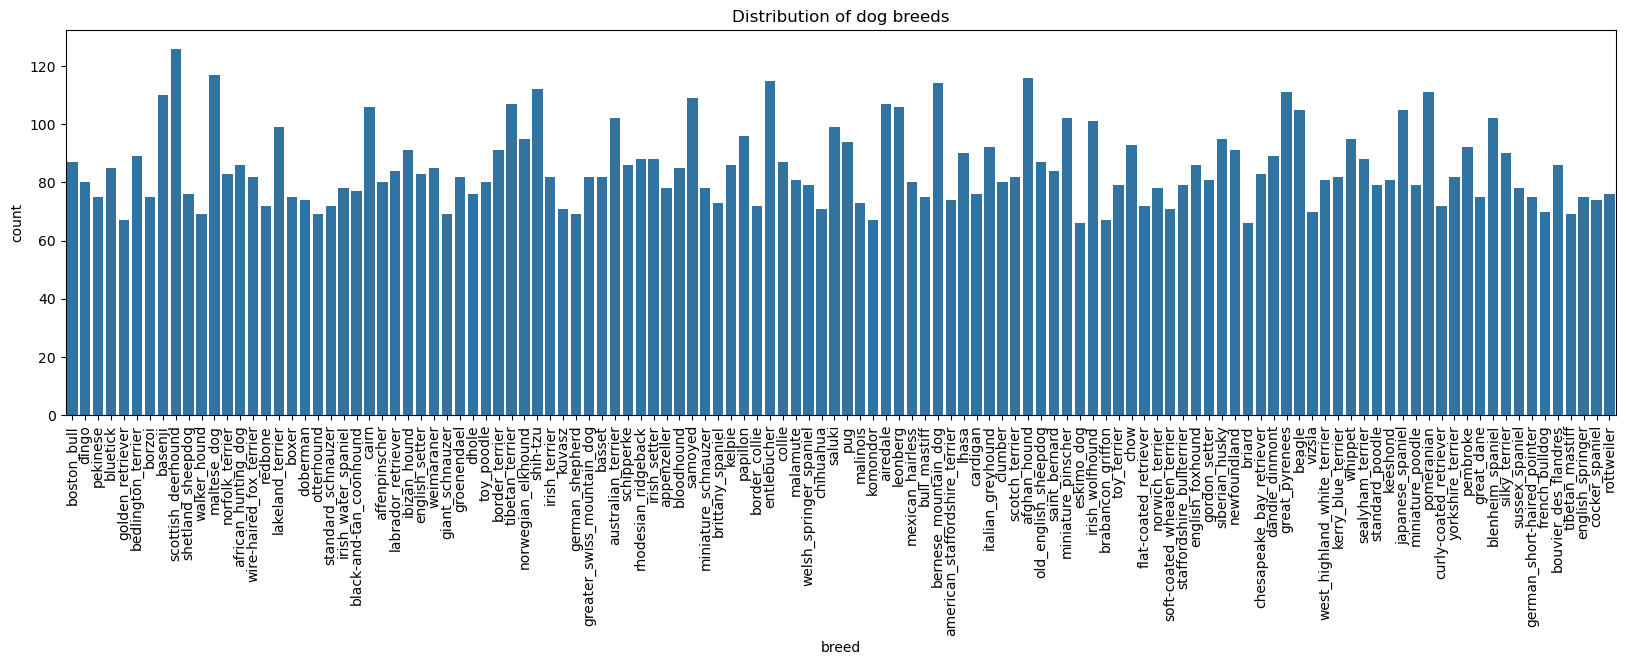

In [9]:
#Anzeigen der Verteilung der Klassen
plt.figure(figsize=(20,5))
plt.xticks(rotation=90)
sns.countplot(data=df, x='breed')
plt.title('Distribution of dog breeds')
plt.show()

## Beispielbilder anzeigen

Zeigt zufällig ausgewählte Trainingsbilder mit ihrer Hunderasse

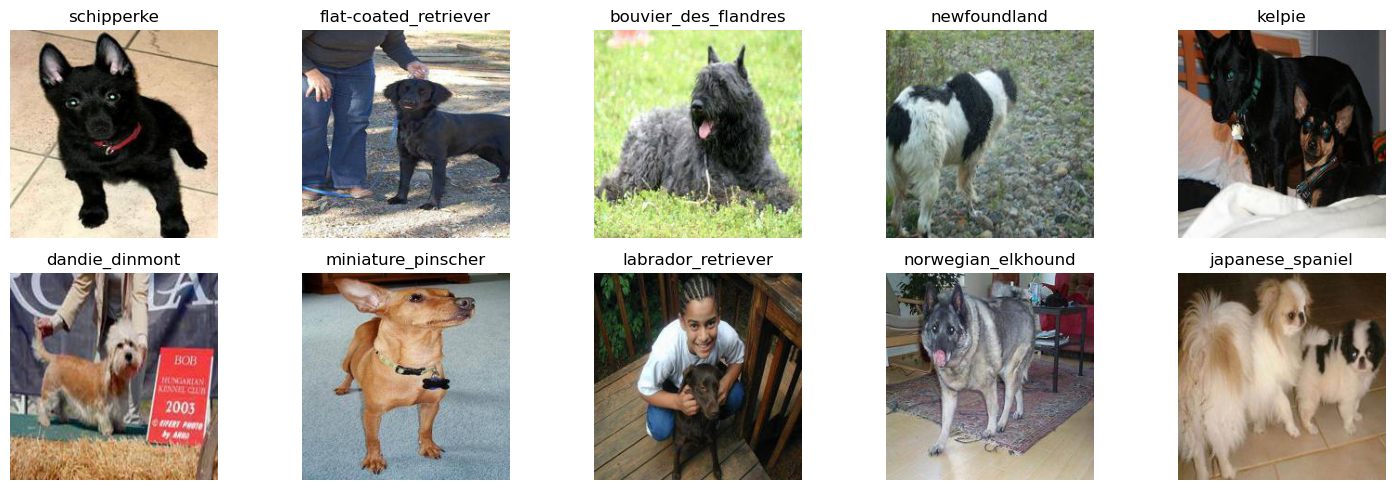

In [10]:
#Sample 10 Bilder aus dem Trainingsset und Anzeigen der Hunderasse
sample_df = df.sample(10)
rows = 2
cols = 5

plt.figure(figsize=(15, 5))

for i, (_, row) in enumerate(sample_df.iterrows()):
    filename = (row['id'] + '.jpg').lower()
    breed = row['breed']
    image = train_images.get(filename)
    
    if image is not None:
        plt.subplot(rows, cols, i + 1)
        plt.imshow(image)
        plt.title(breed)
        plt.axis('off')
    else:
        print(f"Bild nicht gefunden: {filename}")

plt.tight_layout()
plt.show()

In [11]:
# Verknüpft jedes Trainingsbild mit dem passenden Label aus der CSV-Datei
X = []
y = []

# Nur den Namen ohne Erweiterung vergleichen
df['id'] = df['id'].str.replace('.jpg', '', regex=False)  # falls nötig

for filename, image in train_images.items():
    file_id = os.path.splitext(filename)[0]  # z. B. "abc123" aus "abc123.jpg"
    
    if file_id in df['id'].values:
        label = df[df['id'] == file_id]['breed'].values[0]
        X.append(image)
        y.append(label)

X = np.array(X)
y = np.array(y)

In [12]:
# Kodiert die Hunderassen als numerische Klassen und wandelt sie in One-Hot-Vektoren um
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded)

## Trainings- und Validierungsdaten aufteilen 

Teilt die Daten in Trainings- und Validierungssets auf

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y_categorical, test_size=0.2, random_state=42, stratify=y_categorical)

In [14]:
X_train = X_train / 255.0
X_val = X_val / 255.0

## Modell erstellen 

Verwendet MobileNetV2 als Basis und fügt eigene Klassifikationsschichten hinzu

In [15]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam

input_tensor = Input(shape=(224, 224, 3))
base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=input_tensor)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(y_categorical.shape[1], activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
for layer in base_model.layers:
    layer.trainable = False  # Freeze pre-trained layers

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [16]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

Epoch 1/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 149s 558ms/step - accuracy: 0.0428 - loss: 4.6668 - val_accuracy: 0.2626 - val_loss: 3.6655
Epoch 2/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 116s 453ms/step - accuracy: 0.3630 - loss: 3.2066 - val_accuracy: 0.5105 - val_loss: 2.3061
Epoch 3/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 108s 423ms/step - accuracy: 0.5813 - loss: 2.0006 - val_accuracy: 0.6044 - val_loss: 1.6867
Epoch 4/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 111s 436ms/step - accuracy: 0.6769 - loss: 1.4472 - val_accuracy: 0.6435 - val_loss: 1.4105
Epoch 5/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 111s 432ms/step - accuracy: 0.7166 - loss: 1.1827 - val_accuracy: 0.6665 - val_loss: 1.2612
Epoch 6/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 108s 421ms/step - accuracy: 0.7499 - loss: 1.0083 - val_accuracy: 0.6787 - val_loss: 1.1783
Epoch 7/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 109s 425ms/step - accuracy: 0.7736 - loss: 0.9047 - val_accuracy: 0.6807 - val_loss: 1.1203
Epoch 8/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 110s 432ms/step - accuracy: 0.7879 -

In [26]:
from tensorflow.keras.models import load_model

# Modell aus der HDF5-Datei laden
model = load_model("hundemodell.h5")

In [27]:
# Modell-Vorhersagen
y_pred = model.predict(X_val)

# Umwandeln in Klassen-Index
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

64/64 ━━━━━━━━━━━━━━━━━━━━ 40s 605ms/step


## Modell evaluieren 

Berechnet die Confusion Matrix für die Top-N häufigsten Hunderassen und visualisiert die Vorhersagequalität des Modells

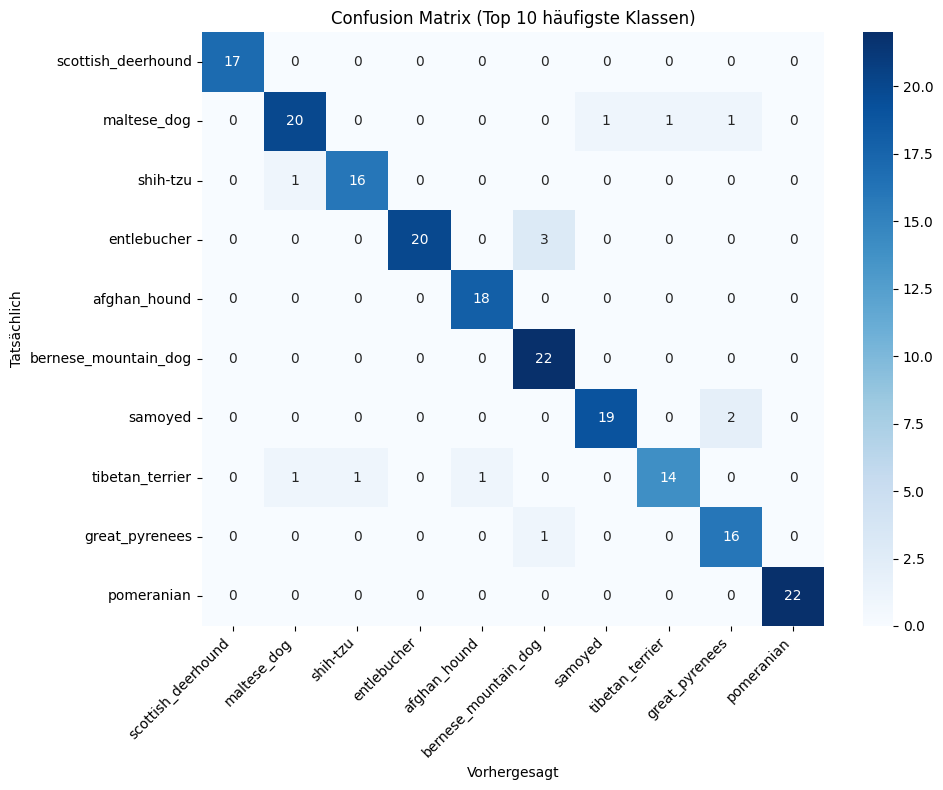

In [28]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Verwirrungsmatrix berechnen
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Nur die häufigsten N Klassen anzeigen
N = 10
class_counts = np.bincount(y_true_classes)
top_classes_idx = np.argsort(class_counts)[::-1][:N]
top_labels = le.classes_[top_classes_idx]

# Verwirrungsmatrix für Top-N Klassen extrahieren
cm_top = cm[np.ix_(top_classes_idx, top_classes_idx)]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_top, annot=True, fmt="d", cmap="Blues", xticklabels=top_labels, yticklabels=top_labels)
plt.xlabel("Vorhergesagt")
plt.ylabel("Tatsächlich")
plt.title(f"Confusion Matrix (Top {N} häufigste Klassen)")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Modell und LabelEncoder speichern

Speichert das trainierte Modell und den LabelEncoder für spätere Verwendung, z.B. für Inferenz oder Deployment

In [30]:
model.save("hundemodell.h5")  # Speichert das gesamte Modell (Architektur + Gewichte)
import pickle

# Speichern des LabelEncoders
with open("labelencoder.pkl", "wb") as f:
    pickle.dump(le, f)